In [73]:
from __future__ import print_function
#%matplotlib inline
import argparse
import os
import sys
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

sys.path.append("../datasets")
from maskdata import MaskedPokemonDataset

# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  999


In [74]:
dataroot = "../sprites"
workers = 2
batch_size = 128 # originally 128

# Spatial size of training images. All images will be resized to this
#   size using a transformer.
image_size = 96 

# Number of channels in the training images. For color images this is 3
nc = 1

# Size of z latent vector (i.e. size of generator input)
nz = 16 # originally 100

# Size of feature maps in generator
ngf = 64

# Size of feature maps in discriminator
ndf = 64

# Number of training epochs
num_epochs = 500

# Learning rate for optimizers
lr = 0.0003

# Beta1 hyperparam for Adam optimizers
beta1 = 0.5

# Number of GPUs available. Use 0 for CPU mode.
ngpu = 1

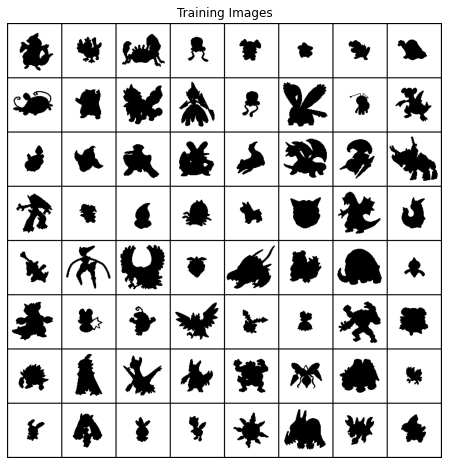

In [75]:
data_path = "../data"
annotations = "../data/masks.csv"

# create dataset
dataset = MaskedPokemonDataset(annotations_file=annotations, 
                               img_dir=data_path, 
                               transform=transforms.Compose([
                               transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                           ]))

# create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size, 
                                         shuffle=True, num_workers=workers)

# decide which device to use
device = torch.device("cuda:0" if (torch.cuda.is_available() and ngpu > 0) else "cpu")

# Plot some training images
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch.to(device)[:64], padding=2, normalize=True).cpu(),(1,2,0)))



In [76]:
# initialize weights
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)

In [77]:
# Code for 3 x 96 x 96 generator
# TO EXPLORE: Add random noise to each layer
class Generator(nn.Module):
    def __init__(self, ngpu):
        super(Generator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input is Z, going into a convolution
            # Major change between tutorial happens here as I need to end up with a 3x96x96 image
            nn.ConvTranspose2d( nz, ngf * 8, 6, 1, 0, bias=False),
            nn.BatchNorm2d(ngf * 8),
            # Original model used an inplace ReLU, ganhacks suggests using leakyReLU in both G and D
            nn.LeakyReLU(0.2, inplace=True), 
            # state size: (ngf*8) x 6 x 6
            nn.ConvTranspose2d(ngf * 8, ngf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ngf*4) x 12 x 12
            nn.ConvTranspose2d(ngf * 4, ngf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ngf*2) x 24 x 24
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ngf) x 48 x 48
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
            # state size: (nc) x 96 x 96
        )
    
    def forward(self, input):
        return self.main(input)

In [78]:
# Create the generator
netG = Generator(ngpu).to(device)

# Handle multi-gpu if desired
if (device.type == 'cuda') and (ngpu > 1):
    netG = nn.DataParallel(netG, list(range(ngpu)))

netG.apply(weights_init)

print(netG)

Generator(
  (main): Sequential(
    (0): ConvTranspose2d(16, 512, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (1): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): LeakyReLU(negative_slope=0.2, inplace=True)
    (3): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (4): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): LeakyReLU(negative_slope=0.2, inplace=True)
    (6): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (7): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): LeakyReLU(negative_slope=0.2, inplace=True)
    (9): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (10): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): LeakyReLU(negative_slope=0.2, inplace=True)
    (12): ConvTransp

In [79]:
class Discriminator(nn.Module):
    def __init__(self, ngpu):
        super(Discriminator, self).__init__()
        self.ngpu = ngpu
        self.main = nn.Sequential(
            # input: (nc) x 96 x 96
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf) x 48 x 48
            nn.Conv2d(ndf, ndf * 2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 2),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 2) x 24 x 24
            nn.Conv2d(ndf * 2, ndf * 4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 4),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 4) x 12 x 12
            nn.Conv2d(ndf * 4, ndf * 8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf * 8),
            nn.LeakyReLU(0.2, inplace=True),
            # state size: (ndf * 8) x 6 x 6
            nn.Conv2d(ndf * 8, 1, 6, 1, 0, bias=False),
            nn.Sigmoid()
        )
    
    def forward(self, input):
        return self.main(input)

In [80]:
# create the discriminator

netD = Discriminator(ngpu).to(device)

# Parallelization
if (device.type == 'cuda') and (ngpu > 1):
    netD = nn.DataParallel(netD, list(range(ngpu)))

netD.apply(weights_init)

print(netD)

Discriminator(
  (main): Sequential(
    (0): Conv2d(1, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (1): LeakyReLU(negative_slope=0.2, inplace=True)
    (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): LeakyReLU(negative_slope=0.2, inplace=True)
    (5): Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (6): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): LeakyReLU(negative_slope=0.2, inplace=True)
    (8): Conv2d(256, 512, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1), bias=False)
    (9): BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (10): LeakyReLU(negative_slope=0.2, inplace=True)
    (11): Conv2d(512, 1, kernel_size=(6, 6), stride=(1, 1), bias=False)
    (12): Sigmoid()
  )
)


In [81]:
# Initialize BCELoss function
criterion = nn.BCELoss()

# Create batch of latent vectors that we will use to visualize the progression of the generator
fixed_noise = torch.randn(64, nz, 1, 1, device=device)

# Establish convention for real and fake labels during training
real_label = 1.
fake_label = 0.

# Setup Adam optimizers for both G and D
optimizerD = optim.Adam(netD.parameters(), lr=lr, betas=(beta1, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=lr, betas=(beta1, 0.999))

In [82]:
# Training loop

# Lists to keep track of progress
img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
# For each epoch
for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, data in enumerate(dataloader, 0):
        
        ############################
        # (1) Update D network: maximize log(D(x)) + log(1 - D(G(z)))
        ###########################
        ## Train with all-real batch
        netD.zero_grad()
        # Format batch
        real_cpu = data.to(device)
        b_size = real_cpu.size(0)
        # label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        label = torch.rand((b_size,), device=device) * .5 + .7
        # Forward pass real batch through D
        output = netD(real_cpu).view(-1)
        # Calculate loss on all-real batch
        errD_real = criterion(output, label)
        # Calculate gradients for D in backward pass
        errD_real.backward()
        D_x = output.mean().item()

        ## Train with all-fake batch
        # Generate batch of latent vectors
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        # Generate fake image batch with G
        fake = netG(noise)
        # label.fill_(fake_label)
        label = torch.rand((b_size,), device=device) * 0.3
        # Classify all fake batch with D
        output = netD(fake.detach()).view(-1)
        # Calculate D's loss on the all-fake batch
        errD_fake = criterion(output, label)
        # Calculate the gradients for this batch, accumulated (summed) with previous gradients
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        # Compute error of D as sum over the fake and the real batches
        errD = errD_real + errD_fake
        # Update D
        optimizerD.step()

        ############################
        # (2) Update G network: maximize log(D(G(z)))
        ###########################
        netG.zero_grad()
        # label.fill_(real_label)  # fake labels are real for generator cost
        label = torch.rand((b_size,), device=device) * .5 + .7
        # Since we just updated D, perform another forward pass of all-fake batch through D
        output = netD(fake).view(-1)
        # Calculate G's loss based on this output
        errG = criterion(output, label)
        # Calculate gradients for G
        errG.backward()
        D_G_z2 = output.mean().item()
        # Update G
        optimizerG.step()

        # Output training stats
        if i % 10 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        # Save Losses for plotting later
        G_losses.append(errG.item())
        D_losses.append(errD.item())

        # Check how the generator is doing by saving G's output on fixed_noise
        if (iters % 500 == 0) or ((epoch == num_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = netG(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))

        iters += 1

Starting Training Loop...
[0/500][0/22]	Loss_D: 2.5791	Loss_G: 2.6037	D(x): 0.3102	D(G(z)): 0.5132 / 0.1106
[0/500][10/22]	Loss_D: 2.0370	Loss_G: 3.9060	D(x): 0.6745	D(G(z)): 0.0657 / 0.0454
[0/500][20/22]	Loss_D: 2.4108	Loss_G: 21.5242	D(x): 0.9047	D(G(z)): 0.7889 / 0.0000
[1/500][0/22]	Loss_D: 5.3852	Loss_G: 10.1693	D(x): 0.9623	D(G(z)): 0.9899 / 0.0001
[1/500][10/22]	Loss_D: 2.0973	Loss_G: 7.4268	D(x): 0.8936	D(G(z)): 0.4515 / 0.0020
[1/500][20/22]	Loss_D: 1.2146	Loss_G: 3.4441	D(x): 0.8796	D(G(z)): 0.4312 / 0.0457
[2/500][0/22]	Loss_D: 0.7841	Loss_G: 2.4087	D(x): 0.8981	D(G(z)): 0.2450 / 0.1110
[2/500][10/22]	Loss_D: 0.7938	Loss_G: 1.5627	D(x): 0.8453	D(G(z)): 0.1216 / 0.2381
[2/500][20/22]	Loss_D: 0.9899	Loss_G: 3.4696	D(x): 0.9455	D(G(z)): 0.3654 / 0.0357
[3/500][0/22]	Loss_D: 0.7339	Loss_G: 1.6669	D(x): 0.9158	D(G(z)): 0.1580 / 0.2226
[3/500][10/22]	Loss_D: 0.7153	Loss_G: 2.9291	D(x): 0.9500	D(G(z)): 0.2473 / 0.0655
[3/500][20/22]	Loss_D: 7.5731	Loss_G: 1.7328	D(x): 0.9997	D(G(z

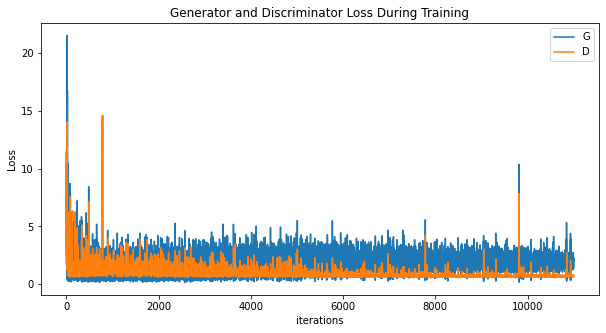

In [83]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

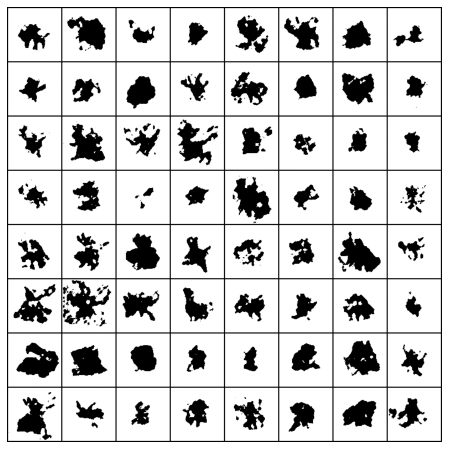

In [84]:
fig = plt.figure(figsize=(8,8))
plt.axis("off")
ims = [[plt.imshow(np.transpose(i,(1,2,0)), animated=True)] for i in img_list]
ani = animation.ArtistAnimation(fig, ims, interval=1000, repeat_delay=1000, blit=True)

HTML(ani.to_jshtml())